In [1]:
import pandas as pd
import skorch
import torch as th
import torch.nn as nn
import numpy as np
from braindecode.models import EEGNetv4
from huggingface_hub import upload_folder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from skorch.net import NeuralNet

from data_utils.dataset import (
    EEGDataset,
    Lee2019Dataset,
)
from configs.Lee2019_ERP_CFG import *

Reading /nvme1/xiejy/projects/Conditional-EEG-Diffusion-main/datasets/Lee2019_ERP-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     992.19 ms
        0 CTF compensation matrices available
Adding metadata with 3 columns
66240 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 4 columns


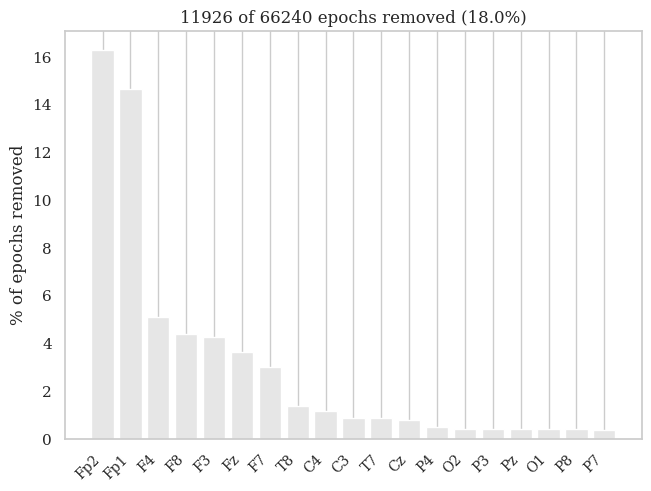

In [2]:
dataset = Lee2019Dataset(**DATASET_CFG)
n_times = dataset.X.shape[2]

In [4]:
# 查看dataset各类信息
print(f"Dataset shape: {dataset.X.shape}")  # (样本数, 通道数, 时间步数)
print(f"dataset y shape: {dataset.y_df.shape}")  # (样本数, 标签数)

Dataset shape: torch.Size([54314, 19, 128])
dataset y shape: (54314, 3)


In [5]:
dataset_name = DATASET_CFG["dataset"]
ch_names = DATASET_CFG["ch_names"]

In [6]:
train_dataset, test_dataset = train_test_split(
    dataset,
    test_size=0.2,
    shuffle=True,
    stratify=dataset.y_df["label"],
)
# 查看数据集划分后的各类信息
print(len(train_dataset))
print(len(test_dataset))

43451
10863


In [8]:
dataset.y_df.columns.to_list()

['subject', 'session', 'label']

In [9]:
label_idx = dataset.y_df.columns.to_list().index("label")
label_idx

2

In [10]:
X_train, y_train = np.array([i[0] for i in train_dataset]), np.array([i[1][label_idx] for i in train_dataset])
X_test, y_test = np.array([i[0] for i in test_dataset]), np.array([i[1][label_idx] for i in test_dataset])

# 查看划分后的数据集各类信息
print(f"X_train shape: {X_train.shape}")  # (样本数, 通道数, 时间步数)
print(f"y_train shape: {y_train.shape}")  # (样本数, 标签数)
print(f"X_test shape: {X_test.shape}")  # (样本数, 通道数, 时间步数)
print(f"y_test shape: {y_test.shape}")  # (样本数, 标签数)

X_train shape: (43451, 19, 128)
y_train shape: (43451,)
X_test shape: (10863, 19, 128)
y_test shape: (10863,)


In [11]:
# initialize model
model = EEGNetv4(
    n_chans=len(ch_names),
    n_outputs=dataset.y_df["label"].nunique(),
    n_times=n_times,
    drop_prob=0.25,
)

In [14]:
print(dataset.rebalanced_weights)
print(dataset.y_df["label"].value_counts())

[1.0, 5.181880264056454]
label
0    45528
1     8786
Name: count, dtype: int64


In [15]:
# initialize loss
criterion = nn.CrossEntropyLoss(weight=th.tensor(dataset.rebalanced_weights))

In [19]:
net = NeuralNet(
    model,
    criterion=criterion,
    max_epochs=100,
    callbacks=[skorch.callbacks.Checkpoint(dirname=f"EEGNet/{dataset_name}")],
    device=RUN_CFG["device"],
)
net = net.initialize()

In [20]:
# train the network
net.fit(X_train, y_train)

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.3207        0.2889     +  2.0871
      2        0.3194        0.2888     +  2.0266
      3        0.3248        0.2871     +  1.9124
      4        0.3209        0.2889        1.7198
      5        0.3176        0.2882        1.8781
      6        0.3190        0.2856     +  2.0508
      7        0.3201        0.2866        2.0841
      8        0.3207        0.2881        2.1157
      9        0.3201        0.2881        2.2548
     10        0.3162        0.2891        1.9702
     11        0.3167        0.2873        1.8719
     12        0.3181        0.2869        1.9463
     13        0.3199        0.2865        1.8713
     14        0.3197        0.2856     +  2.1007
     15        0.3161        0.2843     +  2.0577
     16        0.3142        0.2859        2.1282
     17        0.3148 

<class 'skorch.net.NeuralNet'>[initialized](
  module_=======================================================================================================================================================
  Layer (type (var_name):depth-idx)                  Input Shape               Output Shape              Param #                   Kernel Shape
  ======================================================================================================================================================
  EEGNetv4 (EEGNetv4)                                [1, 19, 128]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                       [1, 19, 128]              [1, 19, 128, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                      [1, 19, 128, 1]           [1, 1, 19, 128]           --                        --
  ├─Conv2d (conv_temporal): 1-3                      [1, 1, 19, 128]           [1, 8, 19, 129]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                [1, 8, 19, 129]           [1, 8, 19, 129]           16                        --
  ├─Conv2dWithConstraint (conv_spatial): 1-5         [1, 8, 19, 129]           [1, 16, 1, 129]           304                       [19, 1]
  ├─BatchNorm2d (bnorm_1): 1-6                       [1, 16, 1, 129]           [1, 16, 1, 129]           32                        --
  ├─Expression (elu_1): 1-7                          [1, 16, 1, 129]           [1, 16, 1, 129]           --                        --
  ├─AvgPool2d (pool_1): 1-8                          [1, 16, 1, 129]           [1, 16, 1, 32]            --                        [1, 4]
  ├─Dropout (drop_1): 1-9                            [1, 16, 1, 32]            [1, 16, 1, 32]            --                        --
  ├─Conv2d (conv_separable_depth): 1-10              [1, 16, 1, 32]            [1, 16, 1, 33]            256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11              [1, 16, 1, 33]            [1, 16, 1, 33]            256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                      [1, 16, 1, 33]            [1, 16, 1, 33]            32                        --
  ├─Expression (elu_2): 1-13                         [1, 16, 1, 33]            [1, 16, 1, 33]            --                        --
  ├─AvgPool2d (pool_2): 1-14                         [1, 16, 1, 33]            [1, 16, 1, 4]             --                        [1, 8]
  ├─Dropout (drop_2): 1-15                           [1, 16, 1, 4]             [1, 16, 1, 4]             --                        --
  ├─Sequential (final_layer): 1-16                   [1, 16, 1, 4]             [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1               [1, 16, 1, 4]             [1, 2, 1, 1]              130                       [1, 4]
  │    └─Rearrange (permute_back): 2-2               [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─Expression (squeeze): 2-3                   [1, 2, 1, 1]              [1, 2]                    --                        --
  ======================================================================================================================================================
  Total params: 1,538
  Trainable params: 1,538
  Non-trainable params: 0
  Total mult-adds (M): 1.31
  ======================================================================================================================================================
  Input size (MB): 0.01
  Forward/backward pass size (MB): 0.36
  Params size (MB): 0.01
  Estimated Total Size (MB): 0.38
  ======================================================================================================================================================,
)

In [21]:
# save the parameters
net.load_params(
    f"EEGNet/{dataset_name}/params.pt",
    f"EEGNet/{dataset_name}/optimizer.pt",
    f"EEGNet/{dataset_name}/criterion.pt",
    f"EEGNet/{dataset_name}/history.json",
)
y_pred = net.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8875080548651385
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      9106
           1       0.60      0.88      0.72      1757

    accuracy                           0.89     10863
   macro avg       0.79      0.88      0.82     10863
weighted avg       0.91      0.89      0.90     10863

